In [11]:
import numpy as np
import matplotlib.pyplot as plt

Here is a link to [py](http://www.argmin.net/code/py)


In [12]:
import numpy as np
import scipy.linalg as LA

def lqr_gain(A,B,Q,R):
  '''
  Arguments:
    State transition matrices (A,B)
    LQR Costs (Q,R)
  Outputs:
    K: optimal infinite-horizon LQR gain matrix given
  '''

  # solve DARE:
  M=LA.solve_discrete_are(A,B,Q,R)

  # K=(B'MB + R)^(-1)*(B'MA)
  return np.dot(LA.inv(np.dot(np.dot(B.T,M),B)+R),(np.dot(np.dot(B.T,M),A)))

def cost_inf_K(A,B,Q,R,K):
  '''
    Arguments:
      State transition matrices (A,B)
      LQR Costs (Q,R)
      Control Gain K
    Outputs:
      cost: Infinite time horizon LQR cost of static gain K
  '''
  cl_map = A+B.dot(K)
  if np.amax(np.abs(LA.eigvals(cl_map)))<(1.0-1.0e-6):
    cost = np.trace(LA.solve_discrete_lyapunov(cl_map.T,Q+np.dot(K.T,R.dot(K))))
  else:
    cost = float("inf")

  return cost

def cost_finite_model(A_true,B_true,Q,R,x0,T,A_dat,B_dat):
  '''
    Arguments:
      True Model state transition matrices (A_true,B_true)
      LQR Costs (Q,R)
      Initial State x0
      Time Horizon T
      Nominal Model state transition matrices (A_dat,B_dat)
    Outputs:
      cost: finite time horizon LQR cost when control is computed using
      (A_dat,B_dat) but executed on system (A_true,B_true)
  '''
  d,p = B_true.shape

  # Ricatti recursion
  M = np.zeros((d,d,T))
  M[:,:,-1]=Q
  for k in range(T-2,-1,-1):
    AMA = np.dot(A_dat.T,M[:,:,k+1].dot(A_dat))
    AMB = np.dot(A_dat.T,M[:,:,k+1].dot(B_dat))
    BMB = np.dot(B_dat.T,M[:,:,k+1].dot(B_dat))
    M[:,:,k] = Q + AMA - np.dot(AMB,LA.inv(R+BMB).dot(AMB.T))

  # compute contols and costs using these Ricatti iterates
  cost = 0
  x = x0
  for k in range(T):
    AMB = np.dot(A_dat.T,M[:,:,k].dot(B_dat))
    BMB = np.dot(B_dat.T,M[:,:,k].dot(B_dat))
    u = -np.dot(LA.inv(R+BMB),np.dot(AMB.T,x))
    x = A_true.dot(x)+B_true.dot(u)
    cost = cost+np.dot(x.T,Q.dot(x))+np.dot(u.T,R.dot(u))

  return cost.flatten()[0]

def cost_finite_K(A_true,B_true,Q,R,x0,T,K):
  '''
    Arguments:
      True Model state transition matrices (A_true,B_true)
      LQR Costs (Q,R)
      Initial State x0
      Time Horizon T
      Static Control Gain K
    Outputs:
      cost: finite time horizon LQR cost when control is static gain K on
      system (A_true,B_true)
  '''

  d,p = B_true.shape

  cost = 0
  x = x0
  for k in range(T):
    u = np.dot(K,x)
    x = A_true.dot(x)+B_true.dot(u)
    cost = cost+np.dot(x.T,Q.dot(x))+np.dot(u.T,R.dot(u))

  return cost.flatten()

def lsqr_estimator(A,B,Q,R,x0,eq_err,N,T):
  '''
    Arguments:
      state transition matrices (A,B)
      LQR Costs (Q,R)
      Initial State x0
      magnitude of noise in dynamics eq_err
      Number of rollouts N
      Time Horizon T
    Outputs:
      Estimated State Transition Matrices (A_nom,B_nom) from least squares
  '''

  d,p = B.shape

  # storage matrices
  X_store = np.zeros((d,N,T+1))
  U_store = np.zeros((p,N,T))

  # simulate
  for k in range(N):
    x = x0
    X_store[:,k,0] = x0.flatten()
    for t in range(T):
      u = np.random.randn(p,1)
      x = A.dot(x)+B.dot(u)+eq_err*np.random.randn(d,1)
      X_store[:,k,t+1] = x.flatten()
      U_store[:,k,t] = u.flatten()

  ### Solve for nominal model
  tmp = np.linalg.lstsq(np.vstack((X_store[:,:,0:T].reshape(d,N*T),
                                U_store.reshape(p,N*T))).T,
                    X_store[:,:,1:(T+1)].reshape(d,N*T).T)[0]
  A_nom = tmp[0:d,:].T
  B_nom = tmp[d:(d+p),:].T
  return (A_nom,B_nom)

def random_search_linear_policy(A,B,Q,R,x0,eq_err,N,T,
    explore_mag = 0.04, step_size = 0.05, batch_size = 4):
  '''
    Arguments:
      state transition matrices (A,B)
      LQR Costs (Q,R)
      Initial State x0
      magnitude of noise in dynamics eq_err
      Number of rollouts N
      Time Horizon T

      hyperparameters:
        explore_mag = magnitude of the noise to explore
        step_size
        batch_size = number of directions per minibatches
        safeguard: maximum absolute value of entries of controller gain

    Outputs:
      Static Control Gain K optimized on LQR cost by random search
  '''

  d,p = B.shape

  # initial condition for K
  K0 = 1e-3*np.random.randn(p,d)
  ###

  #### ALGORITHM
  K = K0
  for k in range(N):
    reward_store = []
    mini_batch = np.zeros((p,d))
    for j in range(batch_size):
      V = np.random.randn(p,d)
      for sign in [-1,1]:
        x = x0
        reward = 0
        for t in range(T):
          u = np.dot(K+sign*explore_mag*V,x)
          x = A.dot(x)+B.dot(u)+eq_err*np.random.randn(d,1)
          reward += -np.dot(x.T,Q.dot(x))-np.dot(u.T,R.dot(u))
        mini_batch += (reward*sign)*V
        reward_store.append(reward)
    K += (step_size/np.std(reward_store)/batch_size)*mini_batch

  return K

def uniform_random_linear_policy(A,B,Q,R,x0,eq_err,N,T,linf_norm=3):
  '''
    Arguments:
      state transition matrices (A,B)
      LQR Costs (Q,R)
      Initial State x0
      magnitude of noise in dynamics eq_err
      Number of rollouts N
      Time Horizon T

      hyperparameters
          linf_norm = maximum absolute value of entries of controller gain

    Outputs:
      Static Control Gain K optimized on LQR cost by uniformly sampling policies
      in bounded region
  '''

  d,p = B.shape

  #### "ALGORITHM"
  best_K = np.empty((p,d))
  best_reward = -float("inf")
  for k in range(N):
    K = np.random.uniform(-linf_norm,linf_norm,(p,d))
    x = x0
    reward = 0
    for t in range(T):
      u = np.dot(K,x)
      x = A.dot(x)+B.dot(u)+eq_err*np.random.randn(d,1)
      reward += -np.dot(x.T,Q.dot(x))-np.dot(u.T,R.dot(u))
    if reward>best_reward:
        best_reward = reward
        best_K = K

  return best_K

import tensorflow as tf

def policy_gradient_adam_linear_policy_pavel(A,B,Q,R,x0,eq_err,N,T,
  explore_mag=0.1, step_size = 0.05, batch_size = 8):
  '''
    Arguments:
      state transition matrices (A,B)
      LQR Costs (Q,R)
      Initial State x0
      magnitude of noise in dynamics eq_err
      Number of rollouts N
      Time Horizon T

      hyperparameters
         explore_mag magnitude of the noise to explore
         step_size
         batch_size: number of stochastic gradients per minibatch
         safeguard: maximum absolute value of entries of controller gain

    Outputs:
      Static Control Gain K optimized on LQR cost by Policy Gradient
  '''
  
  A = A.astype('float32')
  B = B.astype('float32')
  R = R.astype('float32')
  Q = Q.astype('float32')

  # d is obviously the dimension of the observation.
  # p is the dimension of the action, as the name suggests.
  d,p = B.shape
  
  tf.reset_default_graph()
  K = tf.get_variable(
      'policy', shape=[p, d], initializer=tf.zeros_initializer())

  def _policy(x):
    loc = tf.einsum('ijk,lk->ijl', x, K)
    scale = explore_mag
    return tf.distributions.Normal(loc=loc, scale=scale)

  # Training,
  rewards = tf.placeholder(dtype=tf.float32, shape=[batch_size])
  actions = tf.placeholder(dtype=tf.float32, shape=[batch_size, T, p])
  states = tf.placeholder(dtype=tf.float32, shape=[batch_size, T, d])
  action_dist = _policy(states)
  # Log prob of the sequence of actions.
  log_prob = tf.reduce_sum(
      action_dist.log_prob(tf.stop_gradient(actions)), [1, 2])
  advantage = rewards - tf.reduce_mean(rewards)
  loss = -tf.reduce_mean(advantage * log_prob)
  train_op = tf.train.AdamOptimizer(step_size).minimize(loss)
  
  # Playing.
  state = tf.placeholder(dtype=tf.float32, shape=[batch_size, d])
  action = tf.squeeze(_policy(
      tf.expand_dims(state, 1)).sample(), 1)
  noise = tf.distributions.Normal(loc=0.0, scale=eq_err).sample([batch_size, 2])
  next_state = tf.matmul(state, A.T) + tf.matmul(action, B.T) + noise
  next_reward = (-tf.reduce_sum(next_state * tf.matmul(next_state, Q.T), 1) 
                 -tf.reduce_sum(action * tf.matmul(action, R.T), 1))

  #### ALGORITHM
  with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for k in range(N):
      rs = np.zeros(batch_size)
      xs = np.zeros((batch_size, T, d))
      us = np.zeros((batch_size, T, p))
      x = np.tile(x0.reshape([1, d]), [batch_size, 1])
      for t in range(T):
        xs[:, t] = x
        u, x, r = sess.run([action, next_state, next_reward], 
                           feed_dict={state: x})
        us[:, t] = u
        rs += r
      rs /= T
      sess.run(train_op, feed_dict={
          rewards: rs,
          states: xs,
          actions: us,
      })
    return sess.run(K)

def policy_gradient_adam_linear_policy_ben(A,B,Q,R,x0,eq_err,N,T,
    explore_mag = 0.1,step_size = 0.05, batch_size = 8, lag_baseline = False,
    beta1=0.9, beta2=0.999, epsilon=1.0e-8):
    '''
      Arguments:
        state transition matrices (A,B)
        LQR Costs (Q,R)
        Initial State x0
        magnitude of noise in dynamics eq_err
        Number of rollouts N
        Time Horizon T

        hyperparameters
           explore_mag magnitude of the noise to explore
           step_size
           batch_size: number of stochastic gradients per minibatch
           beta1, beta2, epsilon are the additional paramters of Adam

      Outputs:
        Static Control Gain K optimized on LQR cost by Policy Gradient
    '''

    d,p = B.shape

    # initial condition for K
    K0 = 0.0*np.random.randn(p,d)
    ###

    #### ALGORITHM
    K = K0
    baseline = 0.0
    Adam_M = np.zeros((p,d))
    Adam_V = np.zeros((p,d))

    for k in range(N):
      mini_batch = np.zeros((p,d))
      mb_store = np.zeros((p,d,batch_size))
      reward = np.zeros((batch_size))

      # Collect policy gradients for the current minibatch
      for j in range(batch_size):
        x = x0
        X_store = np.zeros((d,T))
        V_store = np.zeros((p,T))
        for t in range(T):
          v = explore_mag*np.random.randn(p,1)
          X_store[:,t] = x.flatten()
          V_store[:,t] = v.flatten()
          u = np.dot(K,x)+v
          x = A.dot(x)+B.dot(u)+eq_err*np.random.randn(d,1)
          reward[j] += -np.dot(x.T,Q.dot(x))-np.dot(u.T,R.dot(u))
        mb_store[:,:,j] = np.dot(V_store,X_store.T)/explore_mag**2 # normalize gradient by variance. Not important.
        
      reward /= T # normalize rewards by T. Not important.

      # Mean of rewards over a minibatch are subtracted from reward. 
      # This is a heuristic for baseline subtraction. If lag_baseline is True,
      # then we use the previous minibatch for the baseline. 
      # Otherwise, we use the current minibatch
      if not lag_baseline:
        baseline = np.mean(reward)
        
      for j in range(batch_size):
        mini_batch += ((reward[j]-baseline)/batch_size)*mb_store[:,:,j]
        
      if lag_baseline:
        baseline = np.mean(reward)

      # Adam Algorithm  
      
      Adam_M = beta1*Adam_M + (1-beta1)*mini_batch
      Adam_V = beta2*Adam_V + (1-beta2)*(mini_batch*mini_batch)
        
      effective_step_size = step_size*np.sqrt(1-beta2**(k+1))/(1-beta1**(k+1))
      K += effective_step_size*Adam_M/(np.sqrt(Adam_V)+epsilon)
    
      #       Adam_M_hat = Adam_M/(1-beta1**(k+1))
      #       Adam_V_hat = Adam_V/(1-beta2**(k+1))
      #       K += step_size*(Adam_M_hat)/(np.sqrt(Adam_V_hat)+epsilon)
    return K

In [13]:
np.random.seed(1337357)

# state transition matrices for linear system: 
#     x(t+1) = A x (t) + B u(t)
A = np.array([[1,1],[0,1]])
B = np.array([[0],[1]])
d,p = B.shape

# LQR quadratic cost per state
Q = np.array([[1,0],[0,0]])

# initial condition for system
z0 = -1 # initial position
v0 = 0  # initial velocity
x0 = np.vstack((z0,v0))

R = np.array([[1.0]])

# number of time steps to simulate
T = 10

# amount of Gaussian noise in dynamics
eq_err = 1e-2

In [14]:
# N_vals = np.floor(np.linspace(1,75,num=7)).astype(int)
N_vals = [1,2,5,7,12,25,50,75,100,125]
N_trials = 10

### Bunch of matrices for storing costs
J_finite_nom = np.zeros((N_trials,len(N_vals)))
J_finite_nomK = np.zeros((N_trials,len(N_vals)))
J_finite_ben = np.zeros((N_trials,len(N_vals)))
J_finite_pavel = np.zeros((N_trials,len(N_vals)))
J_finite_ur = np.zeros((N_trials,len(N_vals)))
J_inf_nom = np.zeros((N_trials,len(N_vals)))
J_inf_ben = np.zeros((N_trials,len(N_vals)))
J_inf_pavel = np.zeros((N_trials,len(N_vals)))
J_inf_ur = np.zeros((N_trials,len(N_vals)))


# cost for finite time horizon, true model
J_finite_opt = cost_finite_model(A,B,Q,R,x0,T,A,B)

### Solve for optimal infinite time horizon LQR controller
K_opt = -lqr_gain(A,B,Q,R)
# cost for infinite time horizon, true model
J_inf_opt = cost_inf_K(A,B,Q,R,K_opt) 

# cost for zero control
baseline = cost_finite_K(A,B,Q,R,x0,T,np.zeros((p,d)))

# model for nominal control with 1 rollout
A_nom1,B_nom1 = lsqr_estimator(A,B,Q,R,x0,eq_err,1,T)
print(A_nom1)
print(B_nom1)

# cost for finite time horizon, one rollout, nominal control
one_rollout_cost = cost_finite_model(A,B,Q,R,x0,T,A_nom1,B_nom1)
K_nom1 = -lqr_gain(A_nom1,B_nom1,Q,R)
one_rollout_cost_inf = cost_inf_K(A,B,Q,R,K_nom1)

for N in range(len(N_vals)):
    for trial in range(N_trials):
        
        # nominal model, N x 40 to match sample budget of policy gradient
        A_nom,B_nom = lsqr_estimator(A,B,Q,R,x0,eq_err,N_vals[N]*40,T);
        # finite time horizon cost with nominal model
        J_finite_nom[trial,N] = cost_finite_model(A,B,Q,R,x0,T,A_nom,B_nom)
        # Solve for infinite time horizon nominal LQR controller
        K_nom = -lqr_gain(A_nom,B_nom,Q,R)
        # cost of using the infinite time horizon solution for finite time horizon
        J_finite_nomK[trial,N] = cost_finite_K(A,B,Q,R,x0,T,K_nom)
        # infinite time horizon cost of nominal model
        J_inf_nom[trial,N] = cost_inf_K(A,B,Q,R,K_nom)

        # policy gradient pavel, batchsize 8 per iteration
        K_pavel = policy_gradient_adam_linear_policy_pavel(A,B,Q,R,x0,eq_err,N_vals[N]*5,T)
        J_finite_pavel[trial,N] = cost_finite_K(A,B,Q,R,x0,T,K_pavel)
        J_inf_pavel[trial,N] = cost_inf_K(A,B,Q,R,K_pavel)
        
        # random search, batchsize 4, so uses 8 rollouts per iteration
        K_ben = policy_gradient_adam_linear_policy_ben(A,B,Q,R,x0,eq_err,N_vals[N]*5,T)
        J_finite_ben[trial,N] = cost_finite_K(A,B,Q,R,x0,T,K_ben)
        J_inf_ben[trial,N] = cost_inf_K(A,B,Q,R,K_ben)

        # uniformly random sampling, N x 40 to match sample budget of policy gradient
        K_ur = random_search_linear_policy(A,B,Q,R,x0,eq_err,N_vals[N]*5,T)
        J_finite_ur[trial,N] = cost_finite_K(A,B,Q,R,x0,T,K_ur)
        J_inf_ur[trial,N] = cost_inf_K(A,B,Q,R,K_ur)

[[  9.99737873e-01   1.00080385e+00]
 [ -1.75083474e-04   1.00226261e+00]]
[[ -6.63942066e-04]
 [  1.00009305e+00]]


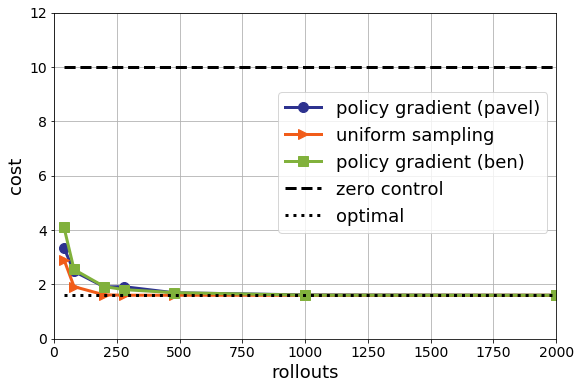

In [15]:
colors = [ '#2D328F', '#F15C19',"#81b13c","#ca49ac"]
          
label_fontsize = 18
tick_fontsize = 14
linewidth = 3
markersize = 10

tot_samples = 40*np.array(N_vals)

plt.plot(tot_samples,np.amin(J_finite_pavel,axis=0),'o-',color=colors[0],linewidth=linewidth,
         markersize=markersize,label='policy gradient (pavel)')

plt.plot(tot_samples,np.amin(J_finite_ur,axis=0),'>-',color=colors[1],linewidth=linewidth,
         markersize=markersize,label='uniform sampling')

plt.plot(tot_samples,np.amin(J_finite_ben,axis=0),'s-',color=colors[2],linewidth=linewidth,
         markersize=markersize,label='policy gradient (ben)')

plt.plot([tot_samples[0],tot_samples[-1]],[baseline, baseline],color='#000000',linewidth=linewidth,
             linestyle='--',label='zero control')
plt.plot([tot_samples[0],tot_samples[-1]],[J_finite_opt, J_finite_opt],color='#000000',linewidth=linewidth,
             linestyle=':',label='optimal')

plt.axis([0,2000,0,12])

plt.xlabel('rollouts',fontsize=label_fontsize)
plt.ylabel('cost',fontsize=label_fontsize)
plt.legend(fontsize=18, bbox_to_anchor=(1.0, 0.54))
plt.xticks(fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)
plt.grid(True)

fig = plt.gcf()
fig.set_size_inches(9, 6)

plt.show()

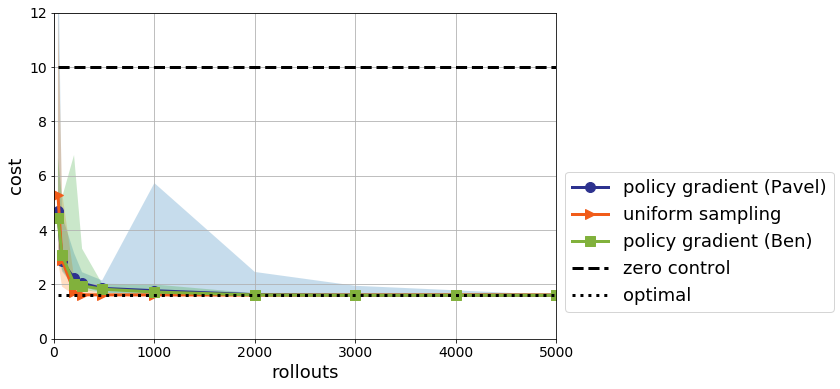

In [16]:
plt.plot(tot_samples,np.median(J_finite_pavel,axis=0),'o-',color=colors[0],linewidth=linewidth,
         markersize=markersize,label='policy gradient (Pavel)')
plt.fill_between(tot_samples, np.amin(J_finite_pavel,axis=0), np.amax(J_finite_pavel,axis=0), alpha=0.25)

plt.plot(tot_samples,np.median(J_finite_ur,axis=0),'>-',color=colors[1],linewidth=linewidth,
         markersize=markersize,label='uniform sampling')
plt.fill_between(tot_samples, np.amin(J_finite_ur,axis=0), np.amax(J_finite_ur,axis=0), alpha=0.25)

plt.plot(tot_samples,np.median(J_finite_ben,axis=0),'s-',color=colors[2],linewidth=linewidth,
         markersize=markersize,label='policy gradient (Ben)')
plt.fill_between(tot_samples, np.amin(J_finite_ben,axis=0), np.amax(J_finite_ben,axis=0), alpha=0.25)


plt.plot([tot_samples[0],tot_samples[-1]],[baseline, baseline],color='#000000',linewidth=linewidth,
             linestyle='--',label='zero control')
plt.plot([tot_samples[0],tot_samples[-1]],[J_finite_opt, J_finite_opt],color='#000000',linewidth=linewidth,
             linestyle=':',label='optimal')

plt.axis([0,5000,0,12])

plt.xlabel('rollouts',fontsize=label_fontsize)
plt.ylabel('cost',fontsize=label_fontsize)
plt.legend(fontsize=18, bbox_to_anchor=(1.0, 0.54))
plt.xticks(fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)
plt.grid(True)

fig = plt.gcf()
fig.set_size_inches(9, 6)

plt.show()

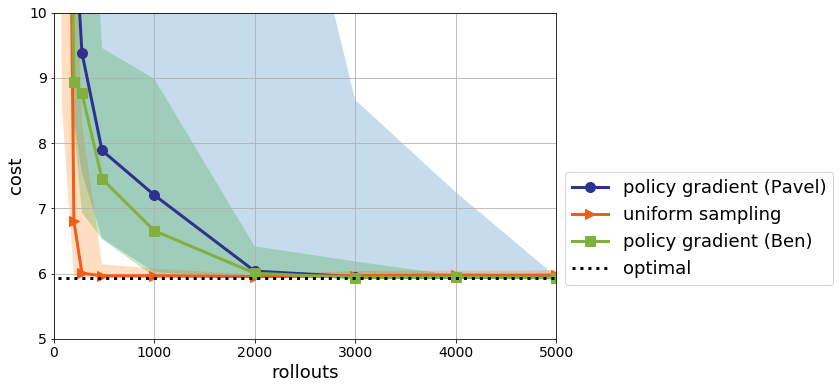

In [17]:
plt.plot(tot_samples,np.median(J_inf_pavel,axis=0),'o-',color=colors[0],linewidth=linewidth,
         markersize=markersize,label='policy gradient (Pavel)')
plt.fill_between(tot_samples, np.amin(J_inf_pavel,axis=0), np.minimum(np.amax(J_inf_pavel,axis=0),15), alpha=0.25)

plt.plot(tot_samples,np.median(J_inf_ur,axis=0),'>-',color=colors[1],linewidth=linewidth,
         markersize=markersize,label='uniform sampling')
plt.fill_between(tot_samples, np.amin(J_inf_ur,axis=0), np.minimum(np.amax(J_inf_ur,axis=0),15), alpha=0.25)

plt.plot(tot_samples,np.median(J_inf_ben,axis=0),'s-',color=colors[2],linewidth=linewidth,
         markersize=markersize,label='policy gradient (Ben)')
plt.fill_between(tot_samples, np.amin(J_inf_ben,axis=0), np.minimum(np.amax(J_inf_ben,axis=0),15), alpha=0.25)

plt.plot([tot_samples[0],tot_samples[-1]],[J_inf_opt, J_inf_opt],color='#000000',linewidth=linewidth,
             linestyle=':',label='optimal')

plt.axis([0,5000,5,10])

plt.xlabel('rollouts',fontsize=label_fontsize)
plt.ylabel('cost',fontsize=label_fontsize)
plt.legend(fontsize=18, bbox_to_anchor=(1.0, 0.54))
plt.xticks(fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)
plt.grid(True)

fig = plt.gcf()
fig.set_size_inches(9, 6)

plt.show()

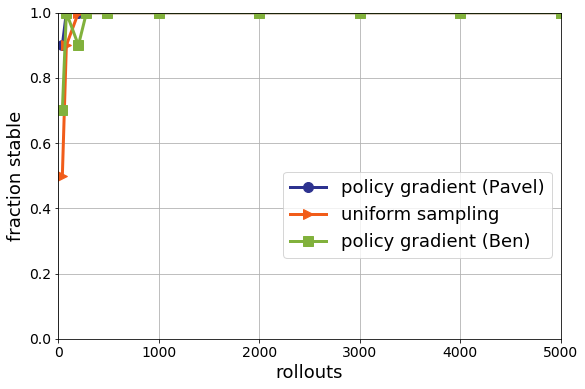

In [18]:
plt.plot(tot_samples,1-np.sum(np.isinf(J_inf_pavel),axis=0)/10,'o-',color=colors[0],linewidth=linewidth,
         markersize=markersize,label='policy gradient (Pavel)')

plt.plot(tot_samples,1-np.sum(np.isinf(J_inf_ur),axis=0)/10,'>-',color=colors[1],linewidth=linewidth,
         markersize=markersize,label='uniform sampling')

plt.plot(tot_samples,1-np.sum(np.isinf(J_inf_ben),axis=0)/10,'s-',color=colors[2],linewidth=linewidth,
         markersize=markersize,label='policy gradient (Ben)')

plt.axis([0,5000,0,1])

plt.xlabel('rollouts',fontsize=label_fontsize)
plt.ylabel('fraction stable',fontsize=label_fontsize)
plt.legend(fontsize=18, bbox_to_anchor=(1.0, 0.54))
plt.xticks(fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)
plt.grid(True)

fig = plt.gcf()
fig.set_size_inches(9, 6)

plt.show()

In [19]:
one_rollout_cost-J_finite_opt

3.0491218016903687e-05

In [20]:
one_rollout_cost_inf-J_inf_opt

7.5407733543642053e-05

In [11]:
J_finite_ben[:,7]

array([ 1.60170865,  1.60225736,  1.62681654,  1.60376096,  2.907627  ,
        1.60770935,  1.7289377 ,  1.71475117,  1.60131019,  1.6400295 ])

In [12]:
J_finite_pavel[:,7]

array([ 1.60351082,  1.62005508,  1.62074781,  1.61415064,  1.60632606,
        1.61238108,  1.60382975,  1.60399489,  1.61449011,  1.60684641])